In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
from google.colab import files
import io

# Upload file to Colab
uploaded_test = files.upload()

# Get the first key from the dictionary (assuming only one file is uploaded)
file_name = list(uploaded_test.keys())[0]

# Use io.BytesIO to create a buffer from the file content
buffer = io.BytesIO(uploaded_test[file_name])

# Read the TSV file from the buffer
df = pd.read_csv(buffer)

Saving drugsComTest_raw.csv to drugsComTest_raw (2).csv


In [ ]:
def review_clean(review):
    # changing to lower case
    lower = review.str.lower()

    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039;", "")

    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')

    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')

    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')

    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')

    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')

    return dataframe

In [ ]:
df['review_clean'] = review_clean(df['review'])

<ipython-input-3-a34c3dd820b2>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
<ipython-input-3-a34c3dd820b2>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
<ipython-input-3-a34c3dd820b2>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
<ipython-input-3-a34c3dd820b2>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
<ipython-input-3-a34c3dd820b2>:21: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')


In [ ]:
pip install nltk


In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
df.head

<bound method NDFrame.head of        uniqueID         drugName                     condition  \
0        163740      Mirtazapine                    Depression   
1        206473       Mesalamine  Crohn's Disease, Maintenance   
2        159672          Bactrim       Urinary Tract Infection   
3         39293         Contrave                   Weight Loss   
4         97768  Cyclafem 1 / 35                 Birth Control   
...         ...              ...                           ...   
53761    159999        Tamoxifen     Breast Cancer, Prevention   
53762    140714     Escitalopram                       Anxiety   
53763    130945   Levonorgestrel                 Birth Control   
53764     47656       Tapentadol                          Pain   
53765    113712        Arthrotec                      Sciatica   

                                                  review  rating       date  \
0      "I&#039;ve tried a few antidepressants over th...      10  28-Feb-12   
1      "My son has 

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer


# Initialize the VADER Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Analyze sentiment using VADER and store the compound score in a new column
df['vader_sentiment'] = df['review_clean'].apply(lambda x: sid.polarity_scores(x)['compound'])



In [ ]:
df.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,vader_sentiment
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22,ive tried a few antidepressants over the years...,-0.4596
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17,my son has crohns disease and has done very we...,0.0736
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3,quick reduction of symptoms,0.0000
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35,contrave combines drugs that were used for alc...,0.4013
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4,i have been on this birth control for one cycl...,0.9472
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4,3-Jul-14,13,4 days in on first 2 weeks using on arms and f...,0.6924
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,6-Jun-16,1,ive had the copper coil for about 3 months now...,0.4688
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9,21-Apr-09,32,this has been great for me ive been on it for ...,0.7842
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7,18-Oct-16,21,ive been on methadone for over ten years and c...,0.2023
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,16-Apr-11,3,i was on this pill for almost two years it doe...,-0.9303


In [ ]:
df.describe()

,uniqueID,rating,usefulCount,vader_sentiment
count,53766.000000,53766.000000,53766.000000,53766.000000
mean,116386.701187,6.976900,27.989752,-0.040912
std,67017.739881,3.285207,36.172833,0.680861
min,0.000000,1.000000,0.000000,-0.997500
25%,58272.500000,4.000000,6.000000,-0.731200
50%,116248.500000,8.000000,16.000000,-0.046000
75%,174586.750000,10.000000,36.000000,0.636900
max,232284.000000,10.000000,949.000000,0.994600


In [ ]:
import nltk
nltk.download('stopwords')
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Removing the stopwords
stop_words = set(stopwords.words('english'))
df['review_clean'] = df['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer


# Initialize the VADER Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Analyze sentiment using VADER and store the compound score in a new column
df['vader_sentiment'] = df['review_clean'].apply(lambda x: sid.polarity_scores(x)['compound'])



In [ ]:
df.head(20)

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,vader_sentiment
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22,ive tried antidepressants years citalopram flu...,0.7623
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17,son crohns disease done well asacol complaints...,0.4767
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3,quick reduction symptoms,0.0000
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35,contrave combines drugs used alcohol smoking o...,0.6435
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4,birth control one cycle reading reviews type s...,0.9529
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4,3-Jul-14,13,4 days first 2 weeks using arms face put vasel...,0.3818
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,6-Jun-16,1,ive copper coil 3 months really excited though...,0.7279
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9,21-Apr-09,32,great ive 2 weeks last week 3 headaches went a...,0.7861
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7,18-Oct-16,21,ive methadone ten years currently trying get d...,0.2023
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,16-Apr-11,3,pill almost two years work far getting pregnan...,-0.9269


In [ ]:
# Define the columns to be created
new_columns = ['Review_Sentiment']

# Specify the index where the new columns should be inserted
insert_index = df.columns.get_loc('rating') + 1

# Insert the new columns to the right of 'HCAHPS Answer Description'
df = pd.concat([df.iloc[:, :insert_index], pd.DataFrame(columns=new_columns), df.iloc[:, insert_index:]], axis=1)

In [ ]:
df.head(10)

,uniqueID,drugName,condition,review,rating,Review_Sentiment,date,usefulCount,review_clean,vader_sentiment
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,NaN,28-Feb-12,22,ive tried antidepressants years citalopram flu...,0.7623
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,NaN,17-May-09,17,son crohns disease done well asacol complaints...,0.4767
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,NaN,29-Sep-17,3,quick reduction symptoms,0.0000
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,NaN,5-Mar-17,35,contrave combines drugs used alcohol smoking o...,0.6435
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,NaN,22-Oct-15,4,birth control one cycle reading reviews type s...,0.9529
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4,NaN,3-Jul-14,13,4 days first 2 weeks using arms face put vasel...,0.3818
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,NaN,6-Jun-16,1,ive copper coil 3 months really excited though...,0.7279
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9,NaN,21-Apr-09,32,great ive 2 weeks last week 3 headaches went a...,0.7861
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7,NaN,18-Oct-16,21,ive methadone ten years currently trying get d...,0.2023
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,NaN,16-Apr-11,3,pill almost two years work far getting pregnan...,-0.9269


In [ ]:
df.loc[df['rating'] >= 7, 'Review_Sentiment'] = 'Positive'
df.loc[df['rating'].isin([5, 6]), 'Review_Sentiment'] = 'Neutral'
df.loc[df['rating'] <= 4, 'Review_Sentiment'] = 'Negative'
#df['Review_Sentiment'] = df['Review_Sentiment'].replace({'Positive': 1, 'Neutral': 2, 'Negative': 0})


In [ ]:
df.head(10)

,uniqueID,drugName,condition,review,rating,Review_Sentiment,date,usefulCount,review_clean,vader_sentiment
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,Positive,28-Feb-12,22,ive tried antidepressants years citalopram flu...,0.7623
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,Positive,17-May-09,17,son crohns disease done well asacol complaints...,0.4767
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,Positive,29-Sep-17,3,quick reduction symptoms,0.0000
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,Positive,5-Mar-17,35,contrave combines drugs used alcohol smoking o...,0.6435
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,Positive,22-Oct-15,4,birth control one cycle reading reviews type s...,0.9529
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4,Negative,3-Jul-14,13,4 days first 2 weeks using arms face put vasel...,0.3818
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,Neutral,6-Jun-16,1,ive copper coil 3 months really excited though...,0.7279
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9,Positive,21-Apr-09,32,great ive 2 weeks last week 3 headaches went a...,0.7861
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7,Positive,18-Oct-16,21,ive methadone ten years currently trying get d...,0.2023
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,Negative,16-Apr-11,3,pill almost two years work far getting pregnan...,-0.9269


In [ ]:
# Save the updated DataFrame to a new CSV file
output_file_path = 'vader.csv'
df.to_csv(output_file_path, index=False)

In [ ]:
# Define the columns to be created
new_columns = ['vader_sentiment_category']

# Specify the index where the new columns should be inserted
insert_index = df.columns.get_loc('review_clean') + 1

# Insert the new columns to the right of 'HCAHPS Answer Description'
df = pd.concat([df.iloc[:, :insert_index], pd.DataFrame(columns=new_columns), df.iloc[:, insert_index:]], axis=1)

In [ ]:
df.head(10)

,uniqueID,drugName,condition,review,rating,Review_Sentiment,date,usefulCount,review_clean,vader_sentiment_category,vader_sentiment
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,Positive,28-Feb-12,22,ive tried antidepressants years citalopram flu...,NaN,0.7623
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,Positive,17-May-09,17,son crohns disease done well asacol complaints...,NaN,0.4767
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,Positive,29-Sep-17,3,quick reduction symptoms,NaN,0.0000
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,Positive,5-Mar-17,35,contrave combines drugs used alcohol smoking o...,NaN,0.6435
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,Positive,22-Oct-15,4,birth control one cycle reading reviews type s...,NaN,0.9529
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4,Negative,3-Jul-14,13,4 days first 2 weeks using arms face put vasel...,NaN,0.3818
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,Neutral,6-Jun-16,1,ive copper coil 3 months really excited though...,NaN,0.7279
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9,Positive,21-Apr-09,32,great ive 2 weeks last week 3 headaches went a...,NaN,0.7861
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7,Positive,18-Oct-16,21,ive methadone ten years currently trying get d...,NaN,0.2023
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,Negative,16-Apr-11,3,pill almost two years work far getting pregnan...,NaN,-0.9269


In [ ]:
# Define custom thresholds for positive and negative sentiment
custom_positive_threshold = 0.4
custom_negative_threshold = -0.2

# Categorize sentiment based on custom thresholds
df['vader_sentiment_category'] = pd.cut(df['vader_sentiment'],
                                         bins=[float('-inf'), custom_negative_threshold, custom_positive_threshold, float('inf')],
                                         labels=['Negative', 'Neutral', 'Positive'])

# Display the DataFrame with VADER sentiment analysis results
print(df[['review_clean', 'vader_sentiment', 'vader_sentiment_category']])


                                            review_clean  vader_sentiment  \
0      ive tried antidepressants years citalopram flu...           0.7623   
1      son crohns disease done well asacol complaints...           0.4767   
2                               quick reduction symptoms           0.0000   
3      contrave combines drugs used alcohol smoking o...           0.6435   
4      birth control one cycle reading reviews type s...           0.9529   
...                                                  ...              ...   
53761  taken tamoxifen 5 years side effects severe sw...          -0.8360   
53762  ive taking lexapro escitaploprgram since febru...           0.8658   
53763  im married 34 years old kids taking pill hassl...          -0.5763   
53764  prescribed nucynta severe neck shoulder pain t...          -0.9260   
53765                                              works           0.0000   

      vader_sentiment_category  
0                     Positive  
1        

In [ ]:
df.head(10)

,uniqueID,drugName,condition,review,rating,Review_Sentiment,date,usefulCount,review_clean,vader_sentiment_category,vader_sentiment
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,Positive,28-Feb-12,22,ive tried antidepressants years citalopram flu...,Positive,0.7623
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,Positive,17-May-09,17,son crohns disease done well asacol complaints...,Positive,0.4767
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,Positive,29-Sep-17,3,quick reduction symptoms,Neutral,0.0000
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,Positive,5-Mar-17,35,contrave combines drugs used alcohol smoking o...,Positive,0.6435
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,Positive,22-Oct-15,4,birth control one cycle reading reviews type s...,Positive,0.9529
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4,Negative,3-Jul-14,13,4 days first 2 weeks using arms face put vasel...,Neutral,0.3818
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,Neutral,6-Jun-16,1,ive copper coil 3 months really excited though...,Positive,0.7279
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9,Positive,21-Apr-09,32,great ive 2 weeks last week 3 headaches went a...,Positive,0.7861
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7,Positive,18-Oct-16,21,ive methadone ten years currently trying get d...,Neutral,0.2023
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,Negative,16-Apr-11,3,pill almost two years work far getting pregnan...,Negative,-0.9269


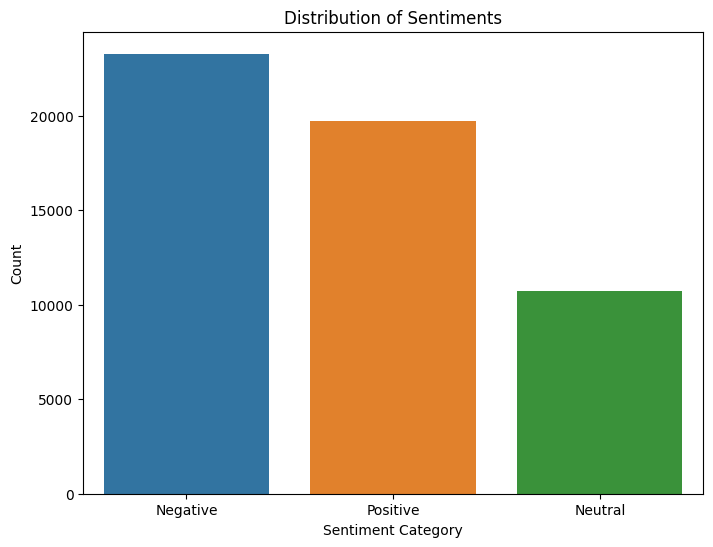

Negative    23285
Positive    19732
Neutral     10749
Name: vader_sentiment_category, dtype: int64


In [ ]:
# Distribution of Sentiments
sentiment_distribution = df['vader_sentiment_category'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
sns.countplot(x='vader_sentiment_category', data=df, order=df['vader_sentiment_category'].value_counts().index)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

# Display sentiment distribution
print(sentiment_distribution)


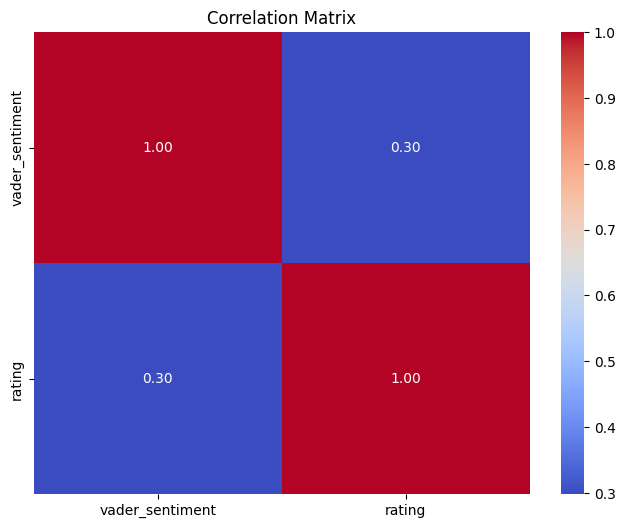

In [ ]:
# Correlation Analysis
correlation_matrix = df[['vader_sentiment', 'rating']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Top Drugs and Conditions by Sentiment
average_sentiment_by_drug = df.groupby('drugName')['vader_sentiment'].mean().sort_values(ascending=False)
average_sentiment_by_condition = df.groupby('condition')['vader_sentiment'].mean().sort_values(ascending=False)

# Display top drugs and conditions
print("Top Drugs by Sentiment:")
print(average_sentiment_by_drug.head(10))

print("\nTop Conditions by Sentiment:")
print(average_sentiment_by_condition.head(10))

Top Drugs by Sentiment:
drugName
Addyi                                                 0.97560
Xopenex HFA                                           0.97500
Inova 4 / 1                                           0.96860
Loprox                                                0.96010
Oxtellar XR                                           0.95590
Doral                                                 0.95520
Acetaminophen / dextromethorphan / pseudoephedrine    0.95450
AbobotulinumtoxinA                                    0.95440
Empagliflozin / metformin                             0.95400
Pyrithione zinc                                       0.95375
Name: vader_sentiment, dtype: float64

Top Conditions by Sentiment:
condition
Hypoactive Sexual Desire Disorde                0.9756
Spondylolisthesis                               0.9547
Mononucleosis                                   0.9468
105</span> users found this comment helpful.    0.9423
Adult Human Growth Hormone Deficiency           0

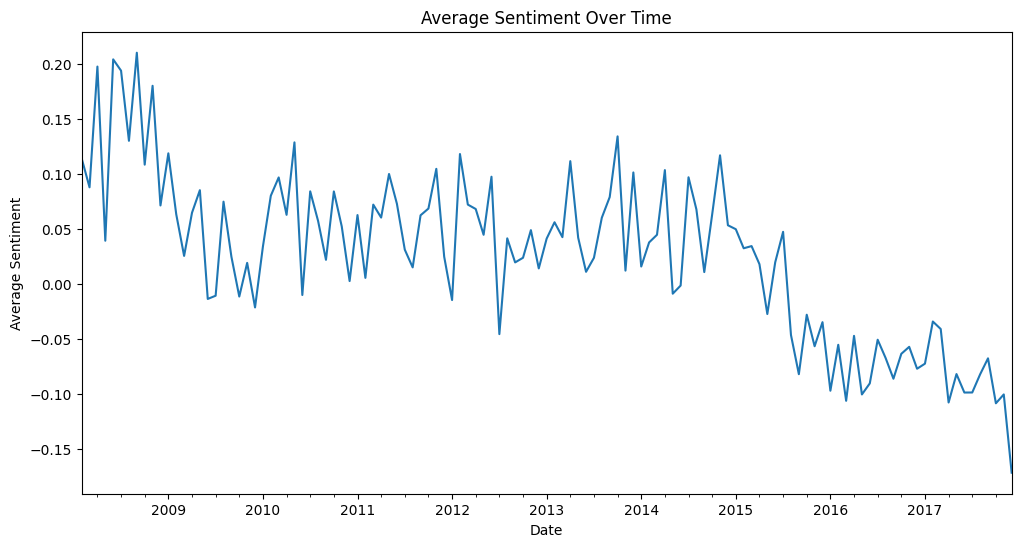

In [ ]:
# Temporal Analysis
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

average_sentiment_by_date = df['vader_sentiment'].resample('M').mean()

plt.figure(figsize=(12, 6))
average_sentiment_by_date.plot()
plt.title('Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.show()

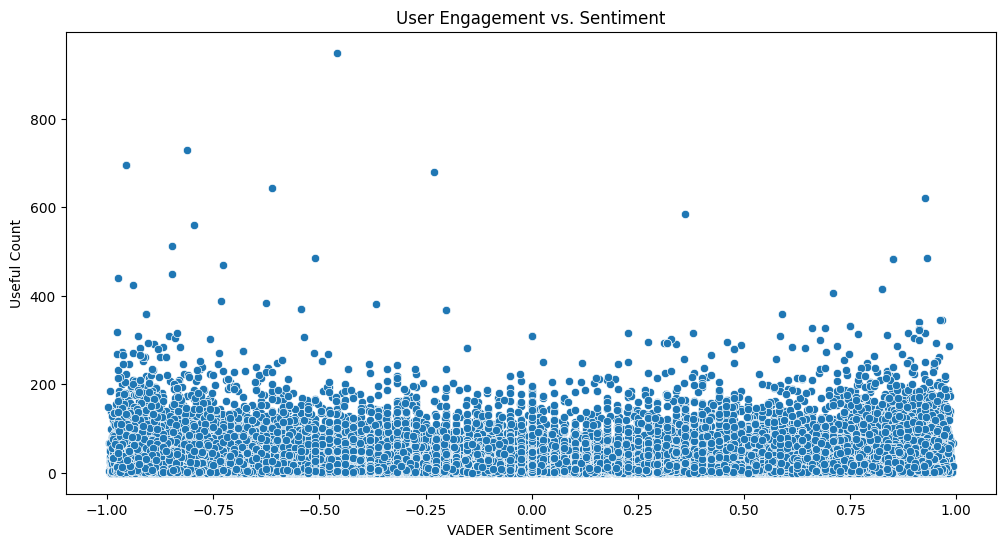

In [ ]:
# User Engagement Analysis
plt.figure(figsize=(12, 6))
sns.scatterplot(x='vader_sentiment', y='usefulCount', data=df)
plt.title('User Engagement vs. Sentiment')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Useful Count')
plt.show()


In [ ]:
df.head(5)

,uniqueID,drugName,condition,review,rating,Review_Sentiment,usefulCount,review_clean,vader_sentiment_category,vader_sentiment
date,,,,,,,,,,
2012-02-28,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,Positive,22,ive tried antidepressants years citalopram flu...,positive,0.7623
2009-05-17,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,Positive,17,son crohns disease done well asacol complaints...,positive,0.4767
2017-09-29,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,Positive,3,quick reduction symptoms,neutral,0.0000
2017-03-05,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,Positive,35,contrave combines drugs used alcohol smoking o...,positive,0.6435
2015-10-22,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,Positive,4,birth control one cycle reading reviews type s...,positive,0.9529


In [ ]:
# Replace 'positive' with 'Positive' in the 'vader_sentiment_category' column
df['vader_sentiment_category'] = df['vader_sentiment_category'].replace('positive', 'Positive')
# Replace 'positive' with 'Positive' in the 'vader_sentiment_category' column
df['vader_sentiment_category'] = df['vader_sentiment_category'].replace('negative', 'Negative')
# Replace 'positive' with 'Positive' in the 'vader_sentiment_category' column
df['vader_sentiment_category'] = df['vader_sentiment_category'].replace('neutral', 'Neutral')


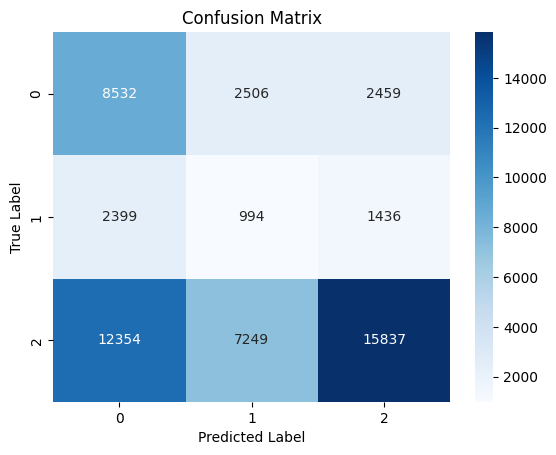

              precision    recall  f1-score   support

    Negative       0.37      0.63      0.46     13497
     Neutral       0.09      0.21      0.13      4829
    Positive       0.80      0.45      0.57     35440

    accuracy                           0.47     53766
   macro avg       0.42      0.43      0.39     53766
weighted avg       0.63      0.47      0.51     53766



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(df['Review_Sentiment'], df['vader_sentiment_category'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Display classification report
class_report = classification_report(df['Review_Sentiment'], df['vader_sentiment_category'])
print(class_report)


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df['Review_Sentiment'], df['vader_sentiment_category'])
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.4717


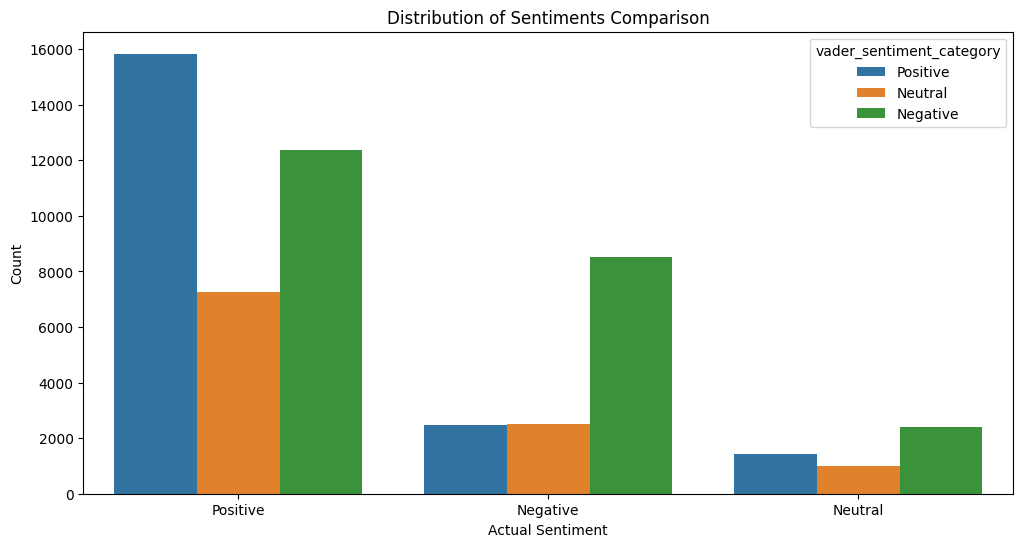

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Review_Sentiment', hue='vader_sentiment_category', data=df)
plt.title('Distribution of Sentiments Comparison')
plt.xlabel('Actual Sentiment')
plt.ylabel('Count')
plt.show()
